# Approximating functions with deep ReLU networks
*Practical session for the course [Mathematic of deep learning](http://www.lsf.tu-berlin.de/qisserver/servlet/de.his.servlet.RequestDispatcherServlet?state=verpublish&status=init&vmfile=no&publishid=233449&moduleCall=webInfo&publishConfFile=webInfo&publishSubDir=veranstaltung), October 2019.*
The content is mostly based on [D. Yarotsky, 2017](https://www.sciencedirect.com/science/article/pii/S0893608017301545).

## Part IV: Approximating functions with Tensorflow networks (exercise)

Let us now realize our approximation theoretic thoughts in Tensorflow 

In [18]:
import numpy as np
import tensorflow as tf
#import target_functions as tfunc
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,9)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 12

### General Setup

Lets start with defining some constants, settings, configurations.

In [10]:
# general settings
DOMAIN = [0.0, 1.0, 0.0, 1.0]   # unit square [0, 1] x [0, 1]
RESOLUTION = 200                # grid resolution for testing the trained model

# network settings
WIDTH = 20              # number of neurons per hidden layer
DEPTH = 6               # total number of layers (number of hidden layers is DEPTH-2)
ACTIVATION = tf.nn.relu # hidden layer activation function

# training settings
INIT_L_RATE  = 2e-1
FINAL_L_RATE = 1e-3
NUM_ITER     = 8000
BATCH_SIZE   = 2048

# setup target function
REGULARITY = [2, 3]
def target_func(x, y):
    '''
    smooth_part = 2*tfunc.bernstein2d(x, y, [2, 3], [3, 4])
    nonsmooth_part = 2*np.math.factorial(REGULARITY[0]) \
        * np.math.factorial(REGULARITY[1]) \
        * tfunc.signpoly2d(x-0.4, y-0.6, REGULARITY)
    return smooth_part + nonsmooth_part
    '''
    return x**2 + np.sqrt(y)


### Define the model

Next we build the neural network computational graph.

In [11]:
# define input and target placeholders
##### ##### COMPLETE THE CODE HERE  ##### #####
'''
 Define tensors for the input and target placeholders here.
 The input should accept feeds of batches of vectors with two components (x and y coordinates).
 The target should accept feeds of batches of vectors with one component (the target function values).
 
 We suggest to use the names 'input' and 'target' for these tensors. If you choose different names you might
 have to adjust something in other parts of the code accordingly.
'''
input = tf.placeholder(dtype=tf.float32, shape=[None, 2], name="input")
target = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="target")
##### ##### ##### ##### ##### ##### ##### #####

##### ##### COMPLETE THE CODE HERE  ##### #####
'''
 Define operations for the hidden layers. Use WIDTH for the number of neurons per hidden layer and ACTIVATION
 for the activation function. Note that we have already put in a loop over the depth of the network, so within the
 loop we only need to specify the operation of a single fully connected layer.
 
 Do not forget about the skip connections in the network architecture used by Yarotsky.
'''
# define hidden layers with forward skip connections
hidden = (DEPTH-1)*[None]
hidden[0] = input
for l in range(DEPTH-2):
    if l == 0:
        hidden[l+1] = tf.layers.dense(
            hidden[0],
            WIDTH,
            activation=ACTIVATION,
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True)
        )
    else:
        hidden[l+1] = tf.layers.dense(
            tf.concat(hidden[:l+1], axis=1),
            WIDTH,
            activation=ACTIVATION,
            kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True)
        )
##### ##### ##### ##### ##### ##### ##### #####
# final layer without ReLU activation
##### ##### COMPLETE THE CODE HERE  ##### #####
'''
 Define operations for the last (output) layer. Remember that the final output layer has only one neuron
 and uses no activation function.
 
 We suggest to use the name 'prediction' for this tensor. If you choose a different name you might
 have to adjust something in other parts of the code accordingly.
'''
##### ##### ##### ##### ##### ##### ##### #####
prediction = tf.layers.dense(tf.concat(hidden, axis=1), 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=True))

### Define the training procedure

Next we define the loss, optimizer, descent steps, and other variable we want to keep track of during training.

In [12]:
# use decaying learning rate
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(
    INIT_L_RATE,
    global_step,
    1,
    np.exp(np.log(FINAL_L_RATE/INIT_L_RATE) / NUM_ITER),
    staircase=True
)

# L2 loss function
# (we want L_inf error, but use smooth L2 error for optimization instead)
##### ##### COMPLETE THE CODE HERE  ##### #####
'''
 Define operations for the loss function. Remember that we will feed batches of input and target vectors
 to the placeholders but the loss always needs to produce a scalar value independant of the batch size, so make
 sure your loss operation can handle different batch sizes.
 
 We suggest to use the name 'loss' for this operation. If you choose a different name you might
 have to adjust something in other parts of the code accordingly.
'''
##### ##### ##### ##### ##### ##### ##### #####
loss = 0.5 * tf.reduce_mean(tf.square(prediction-target))

# Linf error (we can however still monitor this)
error = tf.reduce_max(tf.abs(prediction-target))

# use gradient descent during optimization
step = tf.train.GradientDescentOptimizer(learning_rate).minimize(
    loss,
    global_step=global_step
)

### Bookkeeping

Let us take a short break and print some information to get an overview of the constructed network.

In [15]:
print('\n----------------------------------------------------') 
print(' RUNNING EXPERIMENT WITH THE FOLLOWING PARAMETERS: ')
print('----------------------------------------------------\n')
print('depth:\t\t\t{}'.format(DEPTH))
print('width:\t\t\t{}'.format(WIDTH))
print('number of neurons:\t{}'.format(2+(DEPTH-2)*WIDTH+1))
print('number of connections:\t{}'.format(2+(DEPTH-2)*WIDTH*3+WIDTH*WIDTH*(DEPTH-3)*(DEPTH-2)//2))
print('activation:\t\t{}'.format(ACTIVATION.__name__))
print('learning rate:\t\t{} to {}'.format(INIT_L_RATE, FINAL_L_RATE))
print('iterations:\t\t{}'.format(NUM_ITER))
print('batch size:\t\t{}'.format(BATCH_SIZE))
print('regularity:\t\t{}'.format(REGULARITY))
print('\n\n')


----------------------------------------------------
 RUNNING EXPERIMENT WITH THE FOLLOWING PARAMETERS: 
----------------------------------------------------

depth:			6
width:			20
number of neurons:	83
number of connections:	2642
activation:		relu
learning rate:		0.2 to 0.001
iterations:		8000
batch size:		2048
regularity:		[2, 3]





### Run the training

Let us now start the session and run the training steps.

In [16]:
# start Tensorflow session and initialize all network variables
session = tf.Session()
session.run(tf.global_variables_initializer())

# run gradient descent steps
print('\nStarted training...')
print('{:8s}\t{:8s}\t{:8s}'.format('iter', 'l2-loss', 'linf-err'))
print('{:8s}\t{:8s}\t{:8s}'.format(*(3*[8*'-'])))
for iter in range(NUM_ITER):
    # generate random batch of inputs and corresponding target values
    input_batch = [DOMAIN[1]-DOMAIN[0], DOMAIN[3]-DOMAIN[2]] \
                  * np.random.rand(BATCH_SIZE, 2) \
                  + [DOMAIN[0], DOMAIN[2]]
    target_batch = np.reshape(
        target_func(input_batch[:, 0], input_batch[:, 1]),
        [-1, 1]
    )

    # take gradient descent step and compute loss & error
    loss_val, error_val, _ = session.run(
        [loss, error, step],
        feed_dict={input: input_batch, target: target_batch}
    )
    if iter % 100 == 0:
        print('{:8d}\t{:1.2e}\t{:1.2e}'.format(iter, loss_val, error_val))
print('...finished training.\n')


Started training...
iter    	l2-loss 	linf-err
--------	--------	--------
       0	9.09e-01	2.51e+00
     100	2.52e-03	3.29e-01
     200	1.81e-03	2.70e-01
     300	1.20e-03	2.49e-01
     400	9.58e-04	2.49e-01
     500	8.01e-04	2.40e-01
     600	7.19e-04	2.19e-01
     700	6.95e-04	2.23e-01
     800	5.86e-04	2.15e-01
     900	5.80e-04	2.05e-01
    1000	4.86e-04	1.95e-01
    1100	4.81e-04	2.00e-01
    1200	4.67e-04	1.99e-01
    1300	4.61e-04	2.47e-01
    1400	4.09e-04	2.03e-01
    1500	4.11e-04	1.98e-01
    1600	3.50e-04	2.00e-01
    1700	3.45e-04	1.99e-01
    1800	3.37e-04	1.82e-01
    1900	3.93e-04	1.77e-01
    2000	3.52e-04	1.73e-01
    2100	3.35e-04	1.89e-01
    2200	3.15e-04	1.65e-01
    2300	3.02e-04	1.84e-01
    2400	2.77e-04	2.26e-01
    2500	2.63e-04	1.65e-01
    2600	2.53e-04	1.80e-01
    2700	3.07e-04	1.85e-01
    2800	2.67e-04	1.97e-01
    2900	2.74e-04	1.71e-01
    3000	2.71e-04	1.91e-01
    3100	2.51e-04	1.71e-01
    3200	2.52e-04	1.86e-01
    3300	2.69e-04	1.70e-01
    340

### Evaluate the trained network

After finishing the training phase it is time to check what our network has learned.

Error of predictions after training, evaluated on 200x200 grid:
l2:	2.6515e-04
l2inf:	2.3106e-01


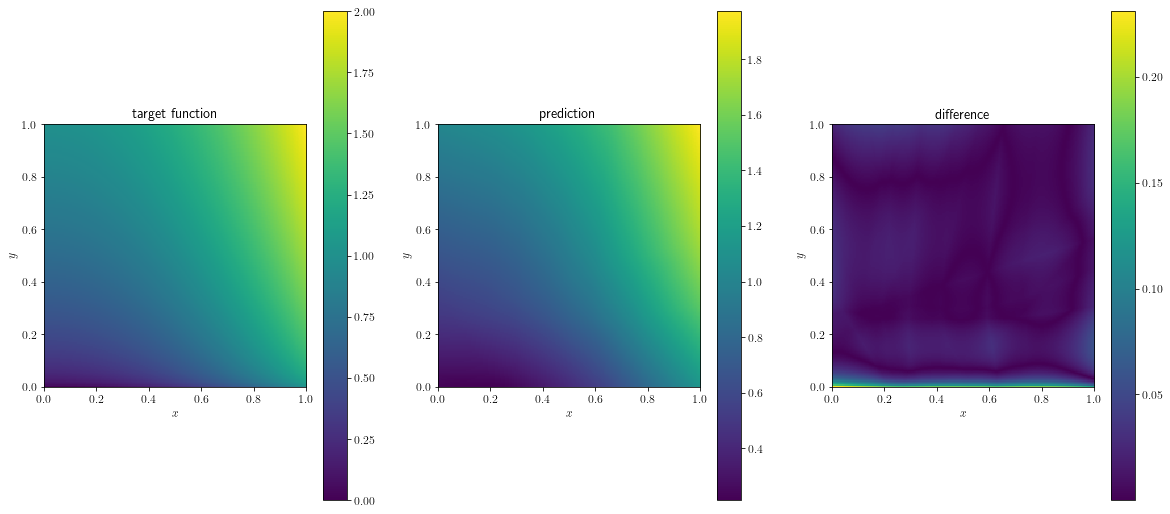

In [19]:
# generate full sample grid of input domain
xrange = np.linspace(DOMAIN[0], DOMAIN[1], num=RESOLUTION)
yrange = np.linspace(DOMAIN[2], DOMAIN[3], num=RESOLUTION)
xgrid, ygrid = np.meshgrid(xrange, yrange)
input_test_batch = np.stack([xgrid.flatten(), ygrid.flatten()], axis=1)

# get model predictions
prediction_test_batch = np.reshape(
    session.run(
        prediction,
        feed_dict={input: input_test_batch}
    ),
    xgrid.shape
)

# get actual target values and compare with predictions
target_test_batch = target_func(xgrid, ygrid)
l2_err = 1/2*np.mean(np.square(prediction_test_batch-target_test_batch))
linf_err = np.max(np.abs(prediction_test_batch-target_test_batch))
print(
    'Error of predictions after training, evaluated on {}x{} grid:'
    .format(RESOLUTION, RESOLUTION)
)
print('l2:\t{:1.4e}'.format(l2_err))
print('l2inf:\t{:1.4e}'.format(linf_err))

# plot actual target, prediction, and comparison
plt.subplot(1,3,1)
plt.imshow(target_test_batch, extent=DOMAIN, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('target function')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(prediction_test_batch, extent=DOMAIN, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('prediction')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(np.abs(target_test_batch-prediction_test_batch), extent=DOMAIN, origin='lower')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('difference')
plt.colorbar()

plt.show()

### Cleanup

Once we are done we can close the session, which will free memory of all our tensors. This is optional, as the session is automatically closed once we close Python.

In [ ]:
session.close()